### This notebook preprocesses text from a twitter airline sentiment [dataset](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment),<br> in preparation for generating embeddings with a sentence transformer model.


In [47]:
import sys

sys.path.append("../")
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
import preprocessing.preprocessing as pp
pd.set_option('display.max_colwidth', None)

In [48]:
# Run these two lines to have all plots appear on GitHub:
import plotly.io as pio

pio.renderers.default = "png"

Reading in the raw data:

In [49]:
df = pd.read_csv("../data/raw/twitter_airline_sentiment.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [50]:
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [51]:
df.tail(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to #BlackBerry10,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


Print number of tweets and number of unique tweets:

In [52]:
print("Number of tweets: ", len(df["text"]))
print("Unique tweets: ", len(set(df["text"])))

Number of tweets:  14640
Unique tweets:  14427


Drop duplicates:

In [53]:
df["original_index"] = df.index
df_nd = df.drop_duplicates(subset=["text"], keep="last", ignore_index=True).copy()
print(len(df_nd))

14427


What do the retweets look like? <br>
Should they be kept?

In [54]:
retweets = [tweet for tweet in df_nd["text"] if "RT" in tweet]
print("Number of retweets in data set: ", len(retweets))
retweets[:10]

Number of retweets in data set:  117


['Nice RT @VirginAmerica: Vibe with the moodlight from takeoff to touchdown. #MoodlitMonday #ScienceBehindTheExperience http://t.co/Y7O0uNxTQP',
 "@VirginAmerica You'd think paying an extra $100 bucks RT for luggage might afford you hiring an extra hand at @sfo #lame",
 "Always have it together!!! You're welcome! RT @VirginAmerica: @jessicajaymes You're so welcome.",
 '😎 RT @VirginAmerica: You’ve met your match. Got status on another airline? Upgrade (+restr): http://t.co/RHKaMx9VF5. http://t.co/PYalebgkJt',
 'Awesome! RT @VirginAmerica: Watch nominated films at 35,000 feet. #MeetTheFleet #Oscars http://t.co/DnStITRzWy',
 "@VirginAmerica If you'd love to see more girls be inspired to become pilots, RT our free WOAW event March 2-8 at ABQ. http://t.co/rfXlV1kGDh",
 'Nice RT @VirginAmerica: The man of steel might be faster, but we have WiFi – just saying. #ScienceBehindTheExperience http://t.co/FGRbpAZSiX',
 '@united Pls Help Baby Hannah get the life saving surgeries she requires.She nee

Print a random sample of tweets:

In [55]:
[print(tweet) for tweet in df_nd["text"].sample(15, random_state=11)];

@united great to hear Thankyou so much. Greatly appreciate your replies. Feel much more settled now.
@united Tell me that you're at least going to cover a room and get me out of here.
@JetBlue I'm over that honestly just would like to get going on the journey.
@USAirways would like to see you do similar in PHL! http://t.co/n9vGe2nPIB
@SouthwestAir if you are giving tix to #DestinationDragons show would appreciate one or two for LA😄Flying from PHL to LAX on Friday
@AmericanAir still waiting on a dm response..... #sloooowresponses
@JetBlue is the trueblue site broken at the moment?
@AmericanAir That's good, I'd expect that but I can't get through on the phone to make any changes. Can I change it online?
@SouthwestAir worst air line ever, you have no compassion of the handicapped
@JetBlue I just wanted to say flight attendant fitz was the best tonight on flight #1326 bwi/Bos. Great guy and made the flight fantastic!
@united no- we are boarding- but why can't your agents, on the phone, tak

### Process tweets through selected preprocessing steps:

In [56]:
df_nd["clean_text"] = df_nd["text"]
df_nd = (
    df_nd.pipe(pp.remove_emoji, col="clean_text", replace=True)
    .pipe(pp.remove_urls, col="clean_text")
    .pipe(pp.remove_html, col="clean_text")
    .pipe(
        pp.remove_symbols,
        col="clean_text",
        symbols=["@", "#"],
        remove_keyword=[True, True],
    )
    .pipe(pp.replace_curly_quotes, col="clean_text")
    .pipe(pp.remove_whitespace_currency, col="clean_text")
    .pipe(pp.fix_whitespace, col="clean_text")
)

/Users/garethsmith/Development/twitter_american_airlines/notebooks/../preprocessing/preprocessing.py:195: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [57]:
# Shows a random subset of tweets before and after cleaning

ind = np.random.choice(len(df_nd), 10)

for t, c in zip(df_nd["text"].to_numpy()[ind], df_nd["clean_text"].to_numpy()[ind]):
    print(f"Original: {t}")
    print(f"Cleaned:  {c}")
    print()

Original: @united Okay, just requested to follow.
Cleaned:  Okay, just requested to follow.

Original: @USAirways ...was Cancelled Flightled and now I need to locate my baggage
Cleaned:  .. .was Cancelled Flightled and now I need to locate my baggage

Original: @AmericanAir You should be more timely with bags that missed a flight, people need their undies the next morning!
Cleaned:  You should be more timely with bags that missed a flight, people need their undies the next morning!

Original: @AmericanAir how have you not loaded our luggage on the plane and were OVER an hour delayed? #Flight293
Cleaned:  how have you not loaded our luggage on the plane and were OVER an hour delayed?

Original: @AmericanAir Thanks for the reply, but a functioning plane four hours ago was the only way to do that. The staff was friendly, tho.
Cleaned:  Thanks for the reply, but a functioning plane four hours ago was the only way to do that. The staff was friendly, tho.

Original: @united Ok thank you, do 

### Using PySpellChecker, we'll find potentially incorrect spellings

In [58]:
df_nd = pp.find_incorrect_spellings(df=df_nd, col="clean_text", distance=1)

In [59]:
# What are the most common spellings we should check?
counter = Counter()
df_nd["check_spellings"].apply(lambda x: counter.update(x.keys()))
counter.most_common()[:50]

[('...', 629),
 ('flightled', 488),
 ('.. .', 270),
 ('w', 247),
 ('dm', 243),
 ('hrs', 218),
 ('flighted', 212),
 ('aa', 179),
 ('..', 173),
 ('jfk', 173),
 ('flightr', 160),
 ("you're", 159),
 (':)', 152),
 ('fleek', 148),
 ('flt', 141),
 ('rebooked', 134),
 ('dfw', 131),
 ('sfo', 102),
 ('thx', 102),
 ('phl', 100),
 ('s', 97),
 ('rt', 94),
 ('jetblue', 94),
 ('dca', 92),
 ('pm', 90),
 (':(', 86),
 ('clt', 77),
 ('bos', 76),
 ('ewr', 71),
 ('nyc', 67),
 ('bc', 67),
 ('hr', 66),
 ('b', 64),
 ('c', 61),
 ('pls', 60),
 ('thru', 55),
 ('phx', 55),
 ('. .', 54),
 ('fll', 51),
 ('cust', 51),
 ('reflight', 51),
 ('lga', 49),
 ('dc', 49),
 ('... .', 48),
 ('1/2', 47),
 ('sw', 46),
 ('usair', 45),
 ('iah', 44),
 ('swa', 43),
 ('flighting', 42)]

### The spellchecker corrections are no use for most of the above, so manual attention is required.
### Manual checking is a fairly large job, but I will cover a subset relating to the unusual versions of "flight" that appear.
### Let's look at the text of the most common of those: 

In [60]:
[(w, counter[w]) for w in counter if "flight" in w and counter[w] > 20]

[('flightled', 488),
 ('flighted', 212),
 ('flightlation', 34),
 ('flighting', 42),
 ('flightr', 160),
 ('flightd', 25),
 ('reflight', 51),
 ('flightlations', 40)]

### Looking at the first of these ("flightled"), they all involve "Cancelled Flightled", which should be corrected to "cancelled":

In [61]:
df_nd["clean_text"][df_nd["clean_text"].str.contains("flightled", case=False)].sample(10)

5345                                                                                       is anyone answering phones to rebook Cancelled Flightled flights?
13835                                                                    anxious to see how you all care for customers you've inconvenienced Flightledflight
5207                                                                             flight 4040 atl to lga Cancelled Flightled any suggestions how to get home?
7825     waiting for a flight to FL for 1/2 marathon tmrw 4 charity. U bumped us 2a Late Flightr flight & then Cancelled FlightLED IT. How can you fix this?
14224                                                                            Flight for tomorrow has already been Cancelled Flightled, what do I do now?
10202                                                                     4 hours on hold to change a Cancelled Flightled flight. Completely unacceptable!!!
5031                                    stuck in NYC fligh

### So we should replace "Cancelled Flightled" with "cancelled" or "Cancelled" as appropriate:

### Now looking at "flighted":

In [62]:
df_nd["clean_text"][df_nd["clean_text"].str.contains("flighted", case=False)].sample(10)

4309                               although I'm not happy you Cancelled Flighted my flight home tomorrow (phx to atl then dca) I am happy on how easy it was to rebook
14408                           I've been on hold for 55 mins about my Cancelled Flighted international flight. Am out of country, so can't leave a call back #. Help?
2436                              All flights Cancelled Flighted:(Trip refunded without difficulty, staff extremely helpful, no complaints! Way to handle bad weather!
10108              my in-laws flight Cancelled Flighted 4 tonight. U auto rebooked 4 flight on Tuesday that doesn't work. Can you help reFlight Booking Problems them?
12708                       my wife was on a flt from BRO to TUL via DFW that was Cancelled Flighted. Bought an SWA flight to get her home. Partial refund, DM me plz?
2425                       I'm on snowy roads to BWI. I Just called MileagePlus & told flight was Cancelled Flighted 1 1/2 hours ago. I rcvd no notification. Pls hel

### Similar story with the above: "Cancelled Flighted" -> "cancelled"

### Now looking at "flightlation":

In [63]:
df_nd["clean_text"][df_nd["clean_text"].str.contains("flightlation", case=False)].sample(10)

11224                             3 delays 2 Cancelled Flightlations a double layover and 72 hours Late Flightr... .could I at least get extra dividend miles?
12211                        travel week, delays, Cancelled Flightlations, "if you want to learn more about the merger press 1", delay my connector in Chicago
3144                                                           it wasn't a delay so much as a straight Cancelled Flightlation. Weather wasn't an issue either.
12689              why are customer svc reps unable to handle calls. Is there a 24hrs Cancelled Flightlation policy? Booked yesterday need to Cancelled Flight
14399                           a friend is having flight Cancelled Flightlations out of LAX to CMH on Feb 23. Anyway to help her? 800 number has been no help
495         my group got their Cancelled Flightlation fees waived but I can't because my ticket is booked for 2/18? Your reps were no help either enraged_face
5127                                         h

### Correction: "Cancelled Flightlations" -> "cancellations" and "Cancelled Flightlation" -> "cancellation":

### Now looking at "flighting":

In [64]:
df_nd["clean_text"][df_nd["clean_text"].str.contains("flighting", case=False)].sample(10)

11579               delayed my flight 3 times before Cancelled Flighting it, had angry and rude workers, and are now providing no helpful service at all
3773                                                             Cancelled Flighting. bought a ticket for a friend but cant get the credit under my name
13106                                  thank you for NOT Cancelled Flighting all flights and putting my husbands life in danger driving in this weather.
4962                                            Way to go flying out of Denver today! Must be the only airline not Cancelled Flighting/delaying flights!
6728        but by Cancelled Flighting my flight and pushing me to the next day I'd lose $150 hotel which was why I was trying to get a same-day flight.
973                    the least you could do is offer me a ticket in coach instead of just Cancelled Flighting my reservation because of your glitch!!!
10079                                             Thanks for Cancelled Flighting m

### This time the correction appears to be "Cancelled Flighting" -> "cancelling":

### Now looking at "flightr":

In [65]:
df_nd["clean_text"][df_nd["clean_text"].str.contains("flightr", case=False)].sample(10)

2439     really fucked my day up Hilo to LAX 2hr30min delay because of software? missed connection, getting home 8hrs Late Flightr no upgrade nothin
1147       Now arriving a day and a half Late Flightr than supposed to. Lesson of the day, don't believe verbal or written confirmations from United
10634                             Made about 30 calls to USAir today to merge of AAdvantage, Dividend Miles. Each time, says call back Late Flightr.
10483                                    What's the seat assignment policy? Why let us choose a seat only to change it on us two weeks Late Flightr?
9520              thx for delayed checkin on noon flt to mia then forcing me to take Late Flightr flts which were delayed. Cincy to Miami in 13 hrs!
2909                             how is it tripitPro has accurate delayed dept. times and 2hours Late Flightr I hear the same from you? Just curious
5246                                                         Left my computer on the plane. Two weeks Late

### This time the correction appears to be "Late Flightr" -> "later":

### Now looking at "flightd":

In [66]:
df_nd["clean_text"][df_nd["clean_text"].str.contains("flightd", case=False)].sample(10)

4659                            Completely understand Act of God weather-reLate Flightd Cancelled Flightlation, but 4 days without reimbursement of any kind is
9905                                              more like USDELAY-ways. Another long 'paperwork' reLate Flightd delay - Friday in Charlotte. Today in Philly.
2016                                             Sorry, . I accidentally popuLate Flightd with you instead of. Can't wait 'til "U" are the only "U" in the sky.
4445     why was Southwest only airline to Cancelled Flight all flights from Charleston? Was 7:50pm flight Cancelled Flightation really weather reLate Flightd?
12376                  btw you guys should consider making a lounge at Austin Intl. airport! Very popuLate Flightd area! Will help the company for sure OK_hand
3971                                             - flight 1114. Unfortunately this isn't an isoLate Flightd incident. I haven't waited less than 20min in years
638                      I asked a legit

### This time the corrections are of the form: "reLate Flightd" -> "related", "unreLate Flightd" -> "unrelated"...

### Now looking at "reflight":

In [67]:
df_nd["clean_text"][df_nd["clean_text"].str.contains("reflight", case=False)].sample(10)

5043     Thx to customer service rep ALEX for his patient help in reFlight Booking Problems a Cancelled Flighted flight and getting us where we have to be tmrw!
1350                                            Now about two dozen back in line to see a single CSR for reFlight Booking Problems final leg. (Kiosks on fritz.)
899                                              Just sent thank u RT: Please DM your confirmation number if reFlight Booking Problems is needed. Thank you. ^EY
7446         When I got your alert, I immediately started looking to rebook. But we only had 11 minutes from reFlight Booking Problems to catch a flight to SRQ.
11495                                                                      stuck in cae need reFlight Booking Problems for next flight possibly dm for more info
12568                                                                                       I need assistance reFlight Booking Problems a flight from dfw to lit
7265                              

### This time the correction seems to be "reFlight Booking Problems" -> "rebooking":

### Let's construct a dataframe of the findings:

In [68]:
text_corrections = {
    "word": [
        "flightled",
        "flighted",
        "flightlations",
        "flightlation",
        "flighting",
        "flightr",
        "flightd",
        "flightd",
        "flightd",
        "flightd",
        "flightd",
        "reflight",
        "reflight",
    ],
    "str_to_replace": [
        "Cancelled Flightled",
        "Cancelled Flighted",
        "Cancelled Flightlations",
        "Cancelled Flightlation",
        "Cancelled Flighting",
        "Late Flightr",
        "unreLate Flightd",
        "correLate Flightd",
        "popuLate Flightd",
        "isoLate Flightd",
        "reLate Flightd",
        "reFlight Booking Problems",
        "ReFlight Booking Problems",
    ],
    "replacement": [
        "cancelled",
        "cancelled",
        "cancellations",
        "cancellation",
        "cancelling",
        "later",
        "unrelated",
        "correlated",
        "populated",
        "isolated",
        "related",
        "rebooking",
        "Rebooking",
    ],
}

df_corrections = pd.DataFrame(text_corrections)
df_corrections

,word,str_to_replace,replacement
0,flightled,Cancelled Flightled,cancelled
1,flighted,Cancelled Flighted,cancelled
2,flightlations,Cancelled Flightlations,cancellations
3,flightlation,Cancelled Flightlation,cancellation
4,flighting,Cancelled Flighting,cancelling
5,flightr,Late Flightr,later
6,flightd,unreLate Flightd,unrelated
7,flightd,correLate Flightd,correlated
8,flightd,popuLate Flightd,populated
9,flightd,isoLate Flightd,isolated


### Now I will replace the bad substrings with the identified replacements:

In [69]:
[pp.replace_substring(df=df_nd, 
                    col="clean_text",
                    str_to_replace=df_corrections["str_to_replace"].iloc[i],
                    replacement=df_corrections["replacement"].iloc[i])
                    for i in df_corrections.index];

### Checking for any remaining issues:

In [70]:
for word in df_corrections["word"].unique():
    print(f"Bad text: {word}. Remaining issues:")
    [print(tweet) for tweet in df_nd["clean_text"] if word in tweet.lower()]
    print()

Bad text: flightled. Remaining issues:
thanks for ruined my vacation for having poorly maintained aircrafts that can't fly safely out of STT. Flightledflight
Flightled.. .tried to get refund but on hold. Can I get it after my flight would have departed?
waiting for a flight to FL for 1/2 marathon tmrw 4 charity. U bumped us 2a later flight & then Cancelled FlightLED IT. How can you fix this?
cannot provide us alternative flight until 36 hours later ruining our trip! Flightled.
anxious to see how you all care for customers you've inconvenienced Flightledflight

Bad text: flighted. Remaining issues:
flighted delayed for hours. 10pm arrival to Vegas is now 4am. Did you seriously lose my luggage???
message me if you want to issue a refund so someone else can use my seats tomorrow AM Flighted
thanks for helping with Booking Problems Flightedflight Yvonne Anthony. You will help us get to Tel Aviv on time.
disappoints AGAIN! Flighted flights appointments refund is a lie
UR service is so shitt

#### There are a few which could be handled separately, but the number is tiny in comparison to before.

### It is apparent that completely cleaning and correcting the text is a large job, but the above addresses some of the most obviously strange faults in the tweet text. Further time spent would be advisable.

### Let's re-do the incorrect spellings check:

In [71]:
df_nd = pp.find_incorrect_spellings(df=df_nd, col="clean_text", distance=1)

In [72]:
counter = Counter()
df_nd["check_spellings"].apply(lambda x: counter.update(x.keys()))
counter.most_common()[:50]

[('...', 629),
 ('.. .', 270),
 ('w', 247),
 ('dm', 243),
 ('hrs', 218),
 ('aa', 179),
 ('..', 173),
 ('jfk', 173),
 ("you're", 159),
 (':)', 152),
 ('fleek', 148),
 ('flt', 141),
 ('rebooked', 134),
 ('dfw', 131),
 ('sfo', 102),
 ('thx', 102),
 ('phl', 100),
 ('s', 97),
 ('rt', 94),
 ('jetblue', 94),
 ('dca', 92),
 ('pm', 90),
 (':(', 86),
 ('clt', 77),
 ('bos', 76),
 ('ewr', 71),
 ('nyc', 67),
 ('bc', 67),
 ('hr', 66),
 ('b', 64),
 ('c', 61),
 ('pls', 60),
 ('thru', 55),
 ('phx', 55),
 ('. .', 54),
 ('fll', 51),
 ('cust', 51),
 ('lga', 49),
 ('dc', 49),
 ('rebooking', 49),
 ('... .', 48),
 ('1/2', 47),
 ('sw', 46),
 ('usair', 45),
 ('iah', 44),
 ('swa', 43),
 ('tv', 41),
 ('mco', 39),
 (';)', 39),
 ('bwi', 39)]

### How long are the tweets? Perhaps very short tweets are not of value?

In [73]:
df_nd["tweet_length"] = df_nd["clean_text"].map(lambda x: len(x))

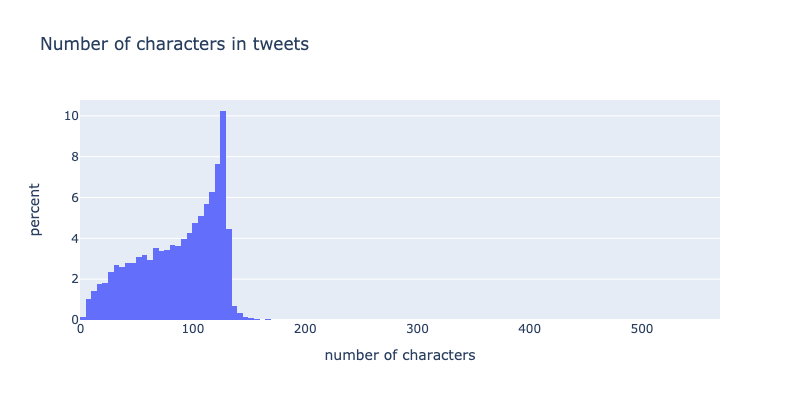

In [74]:
n_char_chart = px.histogram(
    df_nd,
    x="tweet_length",
    nbins=200,
    histnorm="percent",
    labels={"tweet_length": "number of characters"},
    title="Number of characters in tweets",
    width=800,
    height=400,
)
n_char_chart.show()

Very short tweets are nearly all brief replies, e.g. 'thank you' to operators, but mostly contain too little content to be informative individually. Hence I will remove those of three words or less.

In [75]:
# Look at tweets with 3 words or less
short_tweets = df_nd["clean_text"][df_nd["clean_text"].str.count(" ").lt(3)]
[print(tweet) for tweet in short_tweets.sample(15, random_state=11)];

awesome! Thx
Thanks a ton!
snapchat, iMessage, instagram......
thank you!!
I will. Thanks.
thank you
done thnx
flight number
never again.
Apparently not.
Worst airline ever?
yes, with Delta!
Great, thanks. Followed.
please please please
pathetic service


In [76]:
# Drop tweets with 3 words or less
df_nd = df_nd[df_nd["clean_text"].str.count(" ").gt(2)].reset_index(drop=True)
print(df_nd.shape)

(13854, 19)


In [77]:
save_str = "_emoji_urls_html_symbols@#_quotes_currency_whitespace_3wordtweetdrop_flightspellcorrect"

In [78]:
# df_nd.to_csv(
#    f"../data/processed/twitter_airline_sentiment_cleaned{save_str}.csv", index=False
# )